# Data Understanding and Data Preparation

In [3]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import squarify

In [4]:
# load dataframe, make sure no duplicates are present
df = pd.read_csv('datasets/customer_supermarket.csv', sep='\t', index_col=0)
df.drop_duplicates(inplace=True)

# Type checking and basic statistics

In [5]:
df.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,01/12/10 08:26,"2,55",17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,01/12/10 08:26,"2,75",17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,01/12/10 08:26,"3,39",17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466678 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         466678 non-null  object 
 1   BasketDate       466678 non-null  object 
 2   Sale             466678 non-null  object 
 3   CustomerID       401605 non-null  float64
 4   CustomerCountry  466678 non-null  object 
 5   ProdID           466678 non-null  object 
 6   ProdDescr        465925 non-null  object 
 7   Qta              466678 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 32.0+ MB


**First problem:** Sale is of type object while we would have expected it to be float

### Fixing _Sale_:
* Check if any element of _Sale_ contains letters / drop rows containing letters in _Sale_
* Replace commas with dots
* Cast the field into float

In [7]:
# check if any 'Sale' contains letters 
import re
for elem in df['Sale']:
    if re.match(elem, r'[a-zA-Z]*'):
        print(elem)

The attribute _Sale_ does not contain any null value or letters, only numbers.<br>
We need now to substitute commas with dots and cast the field into float

In [8]:
# Replace commas with dots and make 'Sale' a float
df['Sale'].replace(to_replace=r'(\d+),(\d*)', value=r'\1.\2', regex=True, inplace=True)
df['Sale'] = df['Sale'].astype(float)
print('Changed commas into dots')
print('Changed type from str to float64\n')
# drop all rows where sale is zero (free stuff not allowed)
df.drop(df[df['Sale'] < 0.01].index, inplace=True)
df.info()

Changed commas into dots
Changed type from str to float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465394 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         465394 non-null  object 
 1   BasketDate       465394 non-null  object 
 2   Sale             465394 non-null  float64
 3   CustomerID       401561 non-null  float64
 4   CustomerCountry  465394 non-null  object 
 5   ProdID           465394 non-null  object 
 6   ProdDescr        465394 non-null  object 
 7   Qta              465394 non-null  int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 32.0+ MB


We can see we have missing values in CustomerID

In [9]:
df.isnull().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr          False
Qta                False
dtype: bool

### Analyzing _CustomerID_:
* Check for how many orders it's not possible to find a _CustomerID_
* Remove entries with no retrievable _CustomerID_
* Make _CustomerID_ of type **int**

In [10]:
"""
Check for which BaskedIDs it's not possible to find a CustomerID:
    - if a CustomerID is NaN, but there exist a row with the same BaskedID and CustomerID != Nan, 
      then we have a customer for that order.

We produce a dictionary with BaskedIDs as keys and boolean values:
    - if there's a customer for that BaskedID, it's True, otherwise it's False
"""

orders_have_customer = dict(zip(
    df['BasketID'].unique(),    # keys
    [False] * len(df['BasketID'].unique()))  # values (initially False for every key)
)

for index, row in tqdm(df.iterrows(), total=len(df), desc="Checking rows with no CustomerID"):
    if not pd.isna(row['CustomerID']):
        orders_have_customer[row['BasketID']] = True

orders_wo_cust = [] # list of orders without CustomerID
for k, v in orders_have_customer.items():
    if not v:
        orders_wo_cust.append(k)

del orders_have_customer
print("Number of distinct orders: ", len(df['BasketID'].unique()))
print("Number of orders without CustomerID: ", len(orders_wo_cust))


Number of distinct orders:  23562
Number of orders without CustomerID:  1376


In [11]:
# Delete from dataframe records belonging to orders without customer
df = df[~df['BasketID'].isin(orders_wo_cust)]
del orders_wo_cust
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401561 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         401561 non-null  object 
 1   BasketDate       401561 non-null  object 
 2   Sale             401561 non-null  float64
 3   CustomerID       401561 non-null  float64
 4   CustomerCountry  401561 non-null  object 
 5   ProdID           401561 non-null  object 
 6   ProdDescr        401561 non-null  object 
 7   Qta              401561 non-null  int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


In [12]:
# Making CustomerID int value
# Check if the decimal part is always 0
count_decpart_nonzero = 0
for elem in df['CustomerID']:
    if elem % 1.0 != 0.0 and not pd.isnull(elem):
        count_decpart_nonzero += 1
print('Number of CustomerIDs with decimal part != 0: ', count_decpart_nonzero)

Number of CustomerIDs with decimal part != 0:  0


In [13]:
if count_decpart_nonzero == 0:
    df = df.astype({'CustomerID': int})

df.dtypes

BasketID            object
BasketDate          object
Sale               float64
CustomerID           int32
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

***

# Continuing the analysis

In [14]:
df.describe()['Qta']

count    401561.000000
mean         12.149995
std         249.513579
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Qta, dtype: float64

Min value is anomalous

<AxesSubplot:>

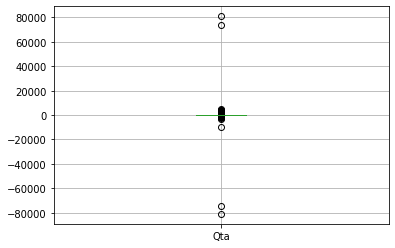

In [15]:
df.boxplot(column=['Qta'])

There are some serious outliers

### Analyzing _Qta_:
* Check rows with **negative** quantity:

In [16]:
df[df['Qta'] < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,01/12/10 09:41,27.50,14527,United Kingdom,D,Discount,-1
154,C536383,01/12/10 09:49,4.65,15311,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,01/12/10 10:24,1.65,17548,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,01/12/10 10:24,0.29,17548,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,01/12/10 10:24,0.29,17548,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


From this print and from further analysis of the csv file we found out that there exist 3 types of BasketIDs (only numbers, starting with C, starting with A)

In [17]:
# Check rows with negative quantity
bid_normal = 0  # counter of rows with normal BasketID (but negative Qta)
neg_df = df[df['Qta'] < 0]

for index, row in tqdm(neg_df.iterrows(), total=len(neg_df), desc="Iterating over negative Qta rows"):
    bid_normal += 1 if (not 'C' in row['BasketID'] and not 'A' in row['BasketID']) else 0

print("Number of rows with negative Qta: ", len(df[df['Qta'] < 0]))
print("Number of rows with negative Qta and a fully numerical BaskedID: ", bid_normal)


Number of rows with negative Qta:  8872
Number of rows with negative Qta and a fully numerical BaskedID:  0


We want to analyze more the negative Qtas pattern:<br>
* does every negative Qta have a corresponding (generically, for now we don't focus on +/- value equality) positive Qta?<br>


In [18]:
all_paired = True
count_pairs = count_not_paired = 0
for index, row in tqdm(df[df['Qta'] < 0].iterrows(), total=len(df[df['Qta'] < 0]), desc='Iterating over negative Qta rows'):
    df_aux = df[df['CustomerID'] == row['CustomerID']]
    df_aux = df_aux[df_aux['ProdID'] == row['ProdID']]
    df_aux = df_aux[df_aux['Qta'] > 0]
    if len(df_aux) > 0:
        count_pairs += 1
    else:
        all_paired = False
        count_not_paired += 1

del df_aux

print("All negative entries have a corresponding positive one: ", all_paired)
print("The negative entries which are not matched are: ", count_not_paired)
print("The negative entries which are matched are: ", count_pairs)
assert(len(df[df['Qta'] < 0]) == count_not_paired + count_pairs)


All negative entries have a corresponding positive one:  False
The negative entries which are not matched are:  947
The negative entries which are matched are:  7925


#### Further checks on entries with a negative quantity:<br>
* We assume them to be returned products, but we need to check that every "negative" product
has a corresponding "positive" one. Moreover it's necessary to be sure that the |(quantity * price)| of a
returned product is <= of (quantity * price) of a corresponding bought one.

* We noticed some of these entries have 'Discount' as product description (ProdID = 'D'), <br>
we want to keep these since we assume they represent relevant information about discounts which customers got during their shopping.

In [19]:
# Initialize variables to analyze correctness of negative Qta rows
# Dictionaries indexed by tuple (CustomerID, ProdID, Sale), value is Qta (or (Qta, list(indexes)) )
pos_quant_tot = {}
neg_quant_tot = {}

for index, row in tqdm(df.iterrows(), total=len(df), desc="Iterating over dataset"):
    if row['Qta'] > 0:
        if (row['CustomerID'], row['ProdID'], row['Sale']) not in pos_quant_tot.keys():
            pos_quant_tot[(row['CustomerID'], row['ProdID'], row['Sale'])] = row['Qta']
        else:
            pos_quant_tot[(row['CustomerID'], row['ProdID'], row['Sale'])] += row['Qta']

    elif row['ProdID'] != 'D':  # exclude 'Discount' rows from those dictionaries --> they won't be dropped from df
        if (row['CustomerID'], row['ProdID'], row['Sale']) not in neg_quant_tot.keys():
            l = [index]
            neg_quant_tot[(row['CustomerID'], row['ProdID'], row['Sale'])] = (-1*row['Qta'], l)
        else:
            prev = neg_quant_tot[(row['CustomerID'], row['ProdID'], row['Sale'])]
            prev[1].append(index)
            neg_quant_tot[(row['CustomerID'], row['ProdID'], row['Sale'])] = (prev[0]-row['Qta'], prev[1])

positive_elements = set(pos_quant_tot.keys())
negative_elements = set(neg_quant_tot.keys())

In [20]:
# drop negative Qta rows that are not matched with positive ones
not_valid = negative_elements - (positive_elements & negative_elements)
indexes_todelete = []
for key in not_valid:
    for x in neg_quant_tot[key][1]:
        indexes_todelete.append(x)
df.drop(indexes_todelete, inplace=True)

In [21]:
# drop negative Qta rows that are invalid ( neg_qta > pos_qta )
indexes_todelete = []
for key in positive_elements & negative_elements:
    if pos_quant_tot[key] < neg_quant_tot[key][0]:
            for x in neg_quant_tot[key][1]:
                indexes_todelete.append(x)
df.drop(indexes_todelete, inplace=True)

***

## Outliers analysis

### _Sale_'s values range:

<AxesSubplot:>

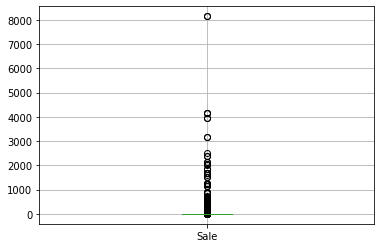

In [22]:
df.boxplot(column=['Sale'])

In [23]:
print(f"Total number of rows: {len(df['Sale'])}")
print(f"Number of rows with a value of 'Sale' > 3000: {len(df[df['Sale'] > 3000])}")
print(f"Number of rows with a value of 'Sale' > 4000: {len(df[df['Sale'] > 4000])}")
print(f"Number of rows with a value of 'Sale' > 8000: {len(df[df['Sale'] > 8000])}")

Total number of rows: 400253
Number of rows with a value of 'Sale' > 3000: 9
Number of rows with a value of 'Sale' > 4000: 5
Number of rows with a value of 'Sale' > 8000: 2


<AxesSubplot:>

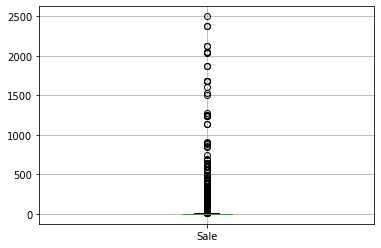

In [24]:
# Only 9 entries over 400K --> we drop this rows and replot the boxplot
df.drop(df[df['Sale'] > 3000].index, inplace=True)
df.boxplot(column=['Sale'])

### _Qta_'s values ranges:

Number of rows with a value of 'Qta' > 10000: 2
Number of rows with a value of 'Qta' < -10000: 2


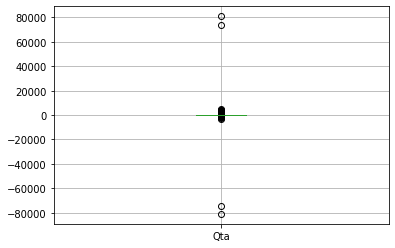

In [25]:
df.boxplot(column=['Qta'])
limit = 10000
print(f"Number of rows with a value of 'Qta' > 10000: {len(df[df['Qta'] > limit])}")
print(f"Number of rows with a value of 'Qta' < -10000: {len(df[df['Qta'] < -limit])}")

In [26]:
# print anomalous rows
print('Rows with a quantity value grater than 60000 or less than -60000:\n')
df[(df['Qta'] > limit) | (df['Qta'] < -limit)]

Rows with a quantity value grater than 60000 or less than -60000:



,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
61619,541431,18/01/11 10:01,1.04,12346,United Kingdom,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215
61624,C541433,18/01/11 10:17,1.04,12346,United Kingdom,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215
540421,581483,09/12/11 09:15,2.08,16446,United Kingdom,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
540422,C581484,09/12/11 09:27,2.08,16446,United Kingdom,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995


For each of the 2 rows with a _Qta_ grater than 60000 there's a row with exactly
the opposite value of _Qta_ and the same _CustomerID_, _ProdID_ and _ProdDescr_.<br>
Even though they "eliminate each other", we drop them because we consider them outliers

<AxesSubplot:>

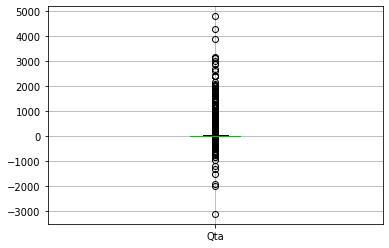

In [27]:
df.drop(df[(df['Qta'] < -limit) | (df['Qta'] > limit)].index, inplace=True)
df.boxplot(column=['Qta'])

# Suspect product IDs analysis

Analyzing Sale we can still see a well defined outlier-like region where Sale > 1000

Total number of rows: 400240
Number of rows with a value of 'Sale' > 1000: 26
Number of rows with a value of 'Sale' > 2000: 8


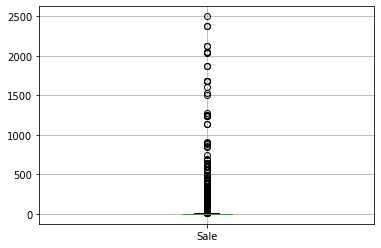

In [28]:
df.boxplot(column=['Sale'])

print(f"Total number of rows: {len(df['Sale'])}")
print(f"Number of rows with a value of 'Sale' > 1000: {len(df[df['Sale'] > 1000])}")
print(f"Number of rows with a value of 'Sale' > 2000: {len(df[df['Sale'] > 2000])}")


In [29]:
df[df['Sale'] > 1000]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
117047,C546325,11/03/11 10:15,1687.17,14911,EIRE,M,Manual,-1
117053,C546327,11/03/11 10:18,1687.17,14911,EIRE,M,Manual,-1
117054,546328,11/03/11 10:19,1687.17,14911,EIRE,M,Manual,1
117055,546329,11/03/11 10:22,1687.17,14911,EIRE,M,Manual,1
144826,548813,04/04/11 13:03,2382.92,12744,Singapore,M,Manual,1
144828,548813,04/04/11 13:03,1252.95,12744,Singapore,M,Manual,1
144829,548820,04/04/11 13:04,2053.07,12744,Singapore,M,Manual,1
144831,C548830,04/04/11 13:08,2382.92,12744,Singapore,M,Manual,-1
144833,C548830,04/04/11 13:08,1252.95,12744,Singapore,M,Manual,-1
144834,C548834,04/04/11 13:09,2053.07,12744,Singapore,M,Manual,-1


We notice this outliers-like values have some particular values in ProdID: M and DOT<br>
And we become curious about the presence of these particular ProdIDs..

In [30]:
print("NON numerical ProdIDs:", df[df['ProdID'].str.contains(r'^\D*$', regex=True)]['ProdID'].unique())

NON numerical ProdIDs: ['POST' 'D' 'M' 'BANK CHARGES' 'DOT']


## ProdID = BANK CHARGES

Number of rows with 'ProdID' = 'BANK CHARGES': 11


<AxesSubplot:>

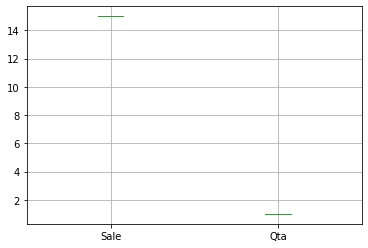

In [31]:
print("Number of rows with 'ProdID' = 'BANK CHARGES':", len(df[df['ProdID'] == 'BANK CHARGES']))
df[df['ProdID'] == 'BANK CHARGES'].boxplot(column = ['Sale','Qta'])

As we can see all these values share the same Sale and Qta, so we assume these entries represent some kind of bank payment that may not be strictly correlated to our customer sale analysis.<br>
Therefore we decide to **DROP** these entries.

In [32]:
df.drop(df[df['ProdID'] == 'BANK CHARGES'].index, inplace=True)

## ProdID = DISCOUNT

We already noticed and discussed about these entries before, we assume the obvious interpretation:<br>
These entries regard discounts on some shopping-related sale about a certain customer. This means it is a relevant set of entries.<br>
Therefore we decide to **KEEP** these entries.

## ProdID = DOT

Number of rows with 'ProdID' = 'DOT': 16
Product description of these entries: ['DOTCOM POSTAGE']


<AxesSubplot:>

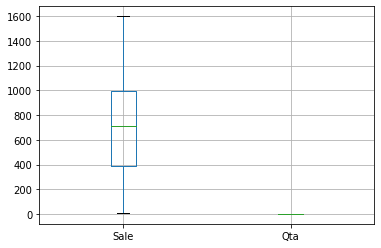

In [33]:
print("Number of rows with 'ProdID' = 'DOT':", len(df[df['ProdID'] == 'DOT']))
print("Product description of these entries:", df[df['ProdID'] == 'DOT']['ProdDescr'].unique())
df[df['ProdID'] == 'DOT'].boxplot(column = ['Sale','Qta'])

In [34]:
df[df['ProdID'] == 'DOT'].describe()

,Sale,CustomerID,Qta
count,16.000000,16.0,16.0
mean,744.147500,14096.0,1.0
std,540.829708,0.0,0.0
min,11.170000,14096.0,1.0
25%,389.082500,14096.0,1.0
50%,715.850000,14096.0,1.0
75%,998.635000,14096.0,1.0
max,1599.260000,14096.0,1.0


We assume these entries have something to do with postage payments (because of their ProdDescr) and so they are not relevant for our customer sale analysis.
Furthermore, by taking a look at the statistics, we can see how these entries have an outlier-like behaviour.<br>
Therefore we decide to **DROP** these entries.

In [35]:
df.drop(df[df['ProdID'] == 'DOT'].index, inplace=True)

## ProdID = POST

Number of rows with 'ProdID' = 'POST': 1133
Product description of these entries: ['POSTAGE']


<AxesSubplot:>

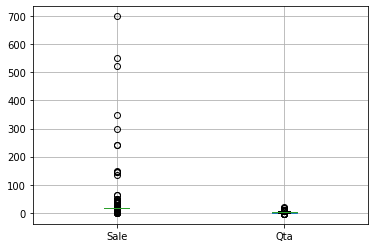

In [36]:
print("Number of rows with 'ProdID' = 'POST':", len(df[df['ProdID'] == 'POST']))
print("Product description of these entries:", df[df['ProdID'] == 'POST']['ProdDescr'].unique())
df[df['ProdID'] == 'POST'].boxplot(column = ['Sale','Qta'])

In [37]:
df[df['ProdID'] == 'POST'].describe()

,Sale,CustomerID,Qta
count,1133.000000,1133.000000,1133.000000
mean,24.158173,12751.902913,2.706090
std,35.383527,723.605361,2.238265
min,1.000000,12348.000000,-4.000000
25%,18.000000,12481.000000,1.000000
50%,18.000000,12601.000000,2.000000
75%,18.000000,12691.000000,3.000000
max,700.000000,17935.000000,21.000000


Even though these entries have a more "normal" behaviour with respect to the entries having ProdID = 'DOT',<br>
we assume these entries ALSO have something to do with postage payments (again because of their ProdDescr) and so they are not relevant for our customer sale analysis.<br>
Therefore we decide to **DROP** these entries too.

In [38]:
df.drop(df[df['ProdID'] == 'POST'].index, inplace=True)

# ProdID = M



Number of rows with 'ProdID' = 'M': 313
Product description of these entries: ['Manual']


<AxesSubplot:>

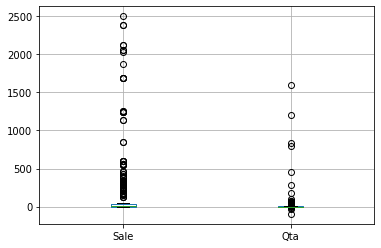

In [39]:
print("Number of rows with 'ProdID' = 'M':", len(df[df['ProdID'] == 'M']))
print("Product description of these entries:", df[df['ProdID'] == 'M']['ProdDescr'].unique())
df[df['ProdID'] == 'M'].boxplot(column = ['Sale','Qta'])

In [40]:
df[df['ProdID'] == 'M'].describe()

,Sale,CustomerID,Qta
count,313.000000,313.000000,313.000000
mean,180.448307,15246.833866,21.546326
std,454.106243,1899.982730,133.637133
min,0.060000,12352.000000,-96.000000
25%,0.790000,13232.000000,1.000000
50%,1.950000,15502.000000,1.000000
75%,40.460000,16965.000000,4.000000
max,2500.000000,18283.000000,1600.000000


Since these entries have all ProdDescr = 'Manual' we assume these entries are describing payments due/received about manual works.<br>
Unfortunately we do not have any more information which can further characterize these entries, they could be referring to a huge plethora of manual topics which may regard (or not) our customer sale analysis.<br>
Therefore we decide to **DROP** these entries. <br>(A look at these entries' statistics highlights even more the fact that this set of samples are anomalies)

In [41]:
df.drop(df[df['ProdID'] == 'M'].index, inplace=True)

### After analyzing all suspect ProdIDs we take a look at Sale again

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
150591,C549452,08/04/11 14:17,1867.86,17940,United Kingdom,D,Discount,-1


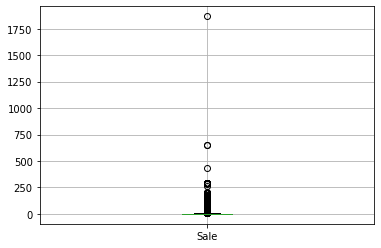

In [42]:
df.boxplot(column=['Sale'])
df[df['Sale'] > 1000]

We now have a much cleaner result, only value being 'abnormal' is a Discount value, which we already decided to maintain.<br>


***

# ANALYZING DATA

**Analyzing number of orders per country**

In [43]:
# orders distribution among countries
basket_country_no_dup = df[['BasketID','CustomerCountry']].drop_duplicates()
country_no_dup = df['CustomerCountry'].unique()
orders_per_country_temp = {}
for country in tqdm(country_no_dup, total = len(country_no_dup), desc = "Computing how many orders per country.."):
    country_df = df[df['CustomerCountry'] == country]
    orders_per_country_temp[country] = len(country_df['BasketID'].unique())

orders_per_country = {'Other':0}

# group small values in 'Other'
for key in orders_per_country_temp.keys():
    if orders_per_country_temp[key] <= np.percentile(list(orders_per_country_temp.values()), 70):
        orders_per_country['Other'] += orders_per_country_temp[key]
    else:
        orders_per_country[key] = orders_per_country_temp[key]
        

    

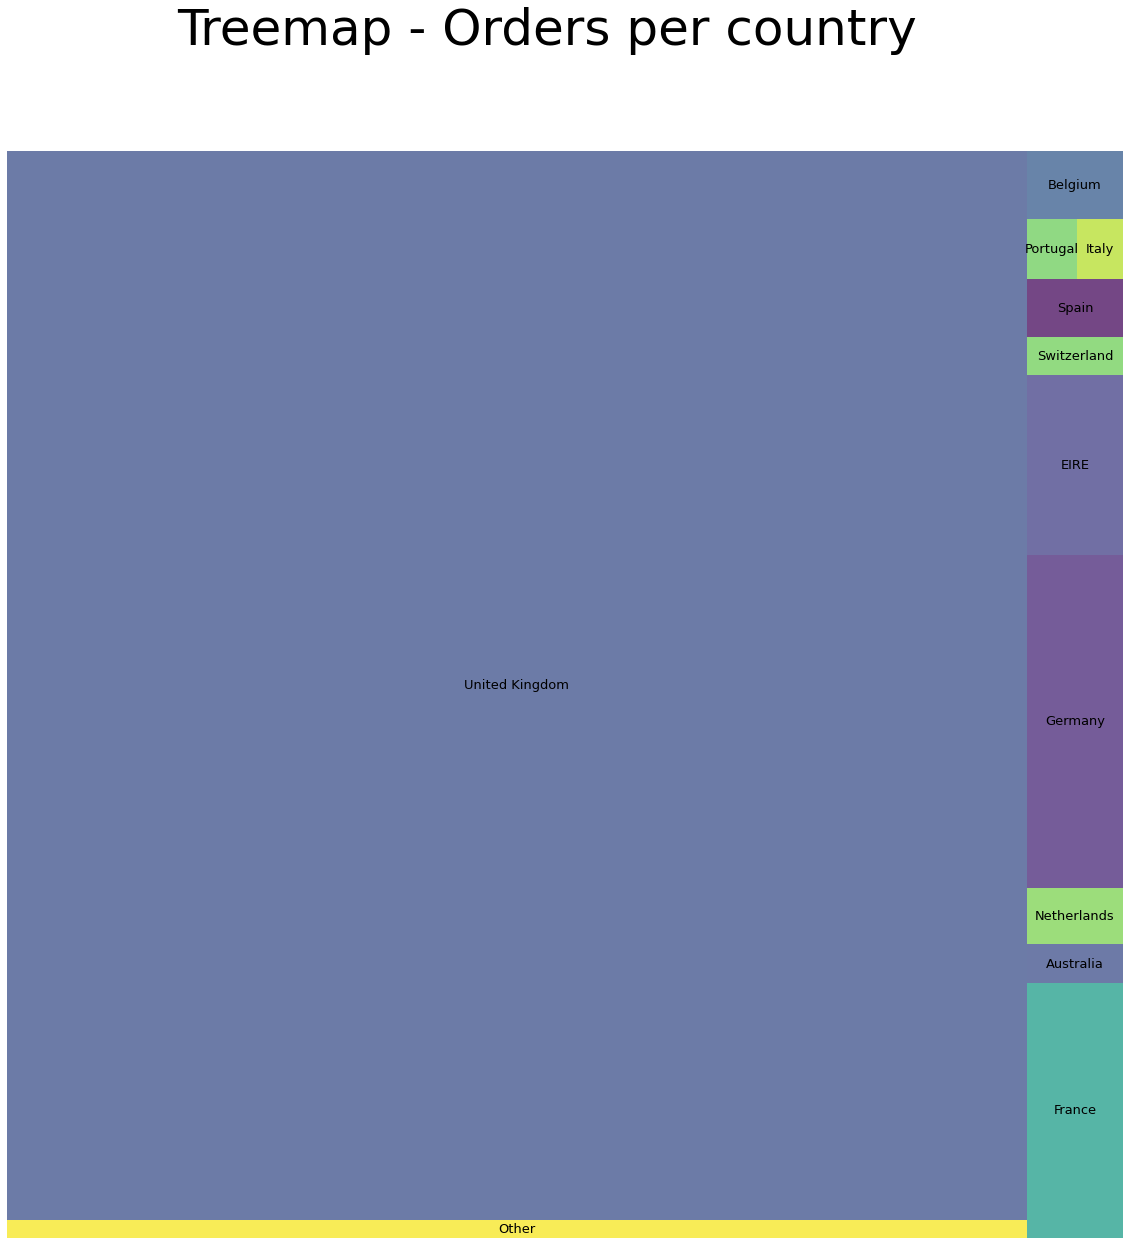

In [44]:
fig, ax = plt.subplots(1, figsize = (20,20))
fig.suptitle("Treemap - Orders per country", fontsize=50)
squarify.plot(sizes=orders_per_country.values(), label=orders_per_country.keys(), text_kwargs={'fontsize':13},alpha=0.75)
plt.axis('off')
plt.show()

**Analyzing most sold products**

In [45]:
# find 10 most requested products ordering by quantity
most_requested = {}
for _,row in tqdm(df.iterrows(), total=len(df), desc="Finding most requested items.."):
    if row['ProdDescr'] not in most_requested:
        most_requested[row['ProdDescr']] = 0
    most_requested[row['ProdDescr']] += row['Qta']
most_requested = sorted(most_requested.items(), key=lambda x: x[1], reverse = True)[:10]

In [46]:
# utility function, just for code reusability
def plot_helper(input_list, text, h = True):
    label_list = []
    qta_list = []
    for pair in input_list:
        label_list.append(pair[0])
        qta_list.append(pair[1])
    plt.figure(figsize=(50, 30))    
    plt.suptitle(text, fontsize=100)
    if h:
        plt.barh(range(len(qta_list)),qta_list)
        plt.yticks(range(len(label_list)), label_list, fontsize=40)
    else:
        plt.bar(range(len(qta_list)),qta_list)
        plt.xticks(range(len(label_list)), label_list, fontsize=40)
    plt.tick_params(axis='both', which='major', labelsize=40)

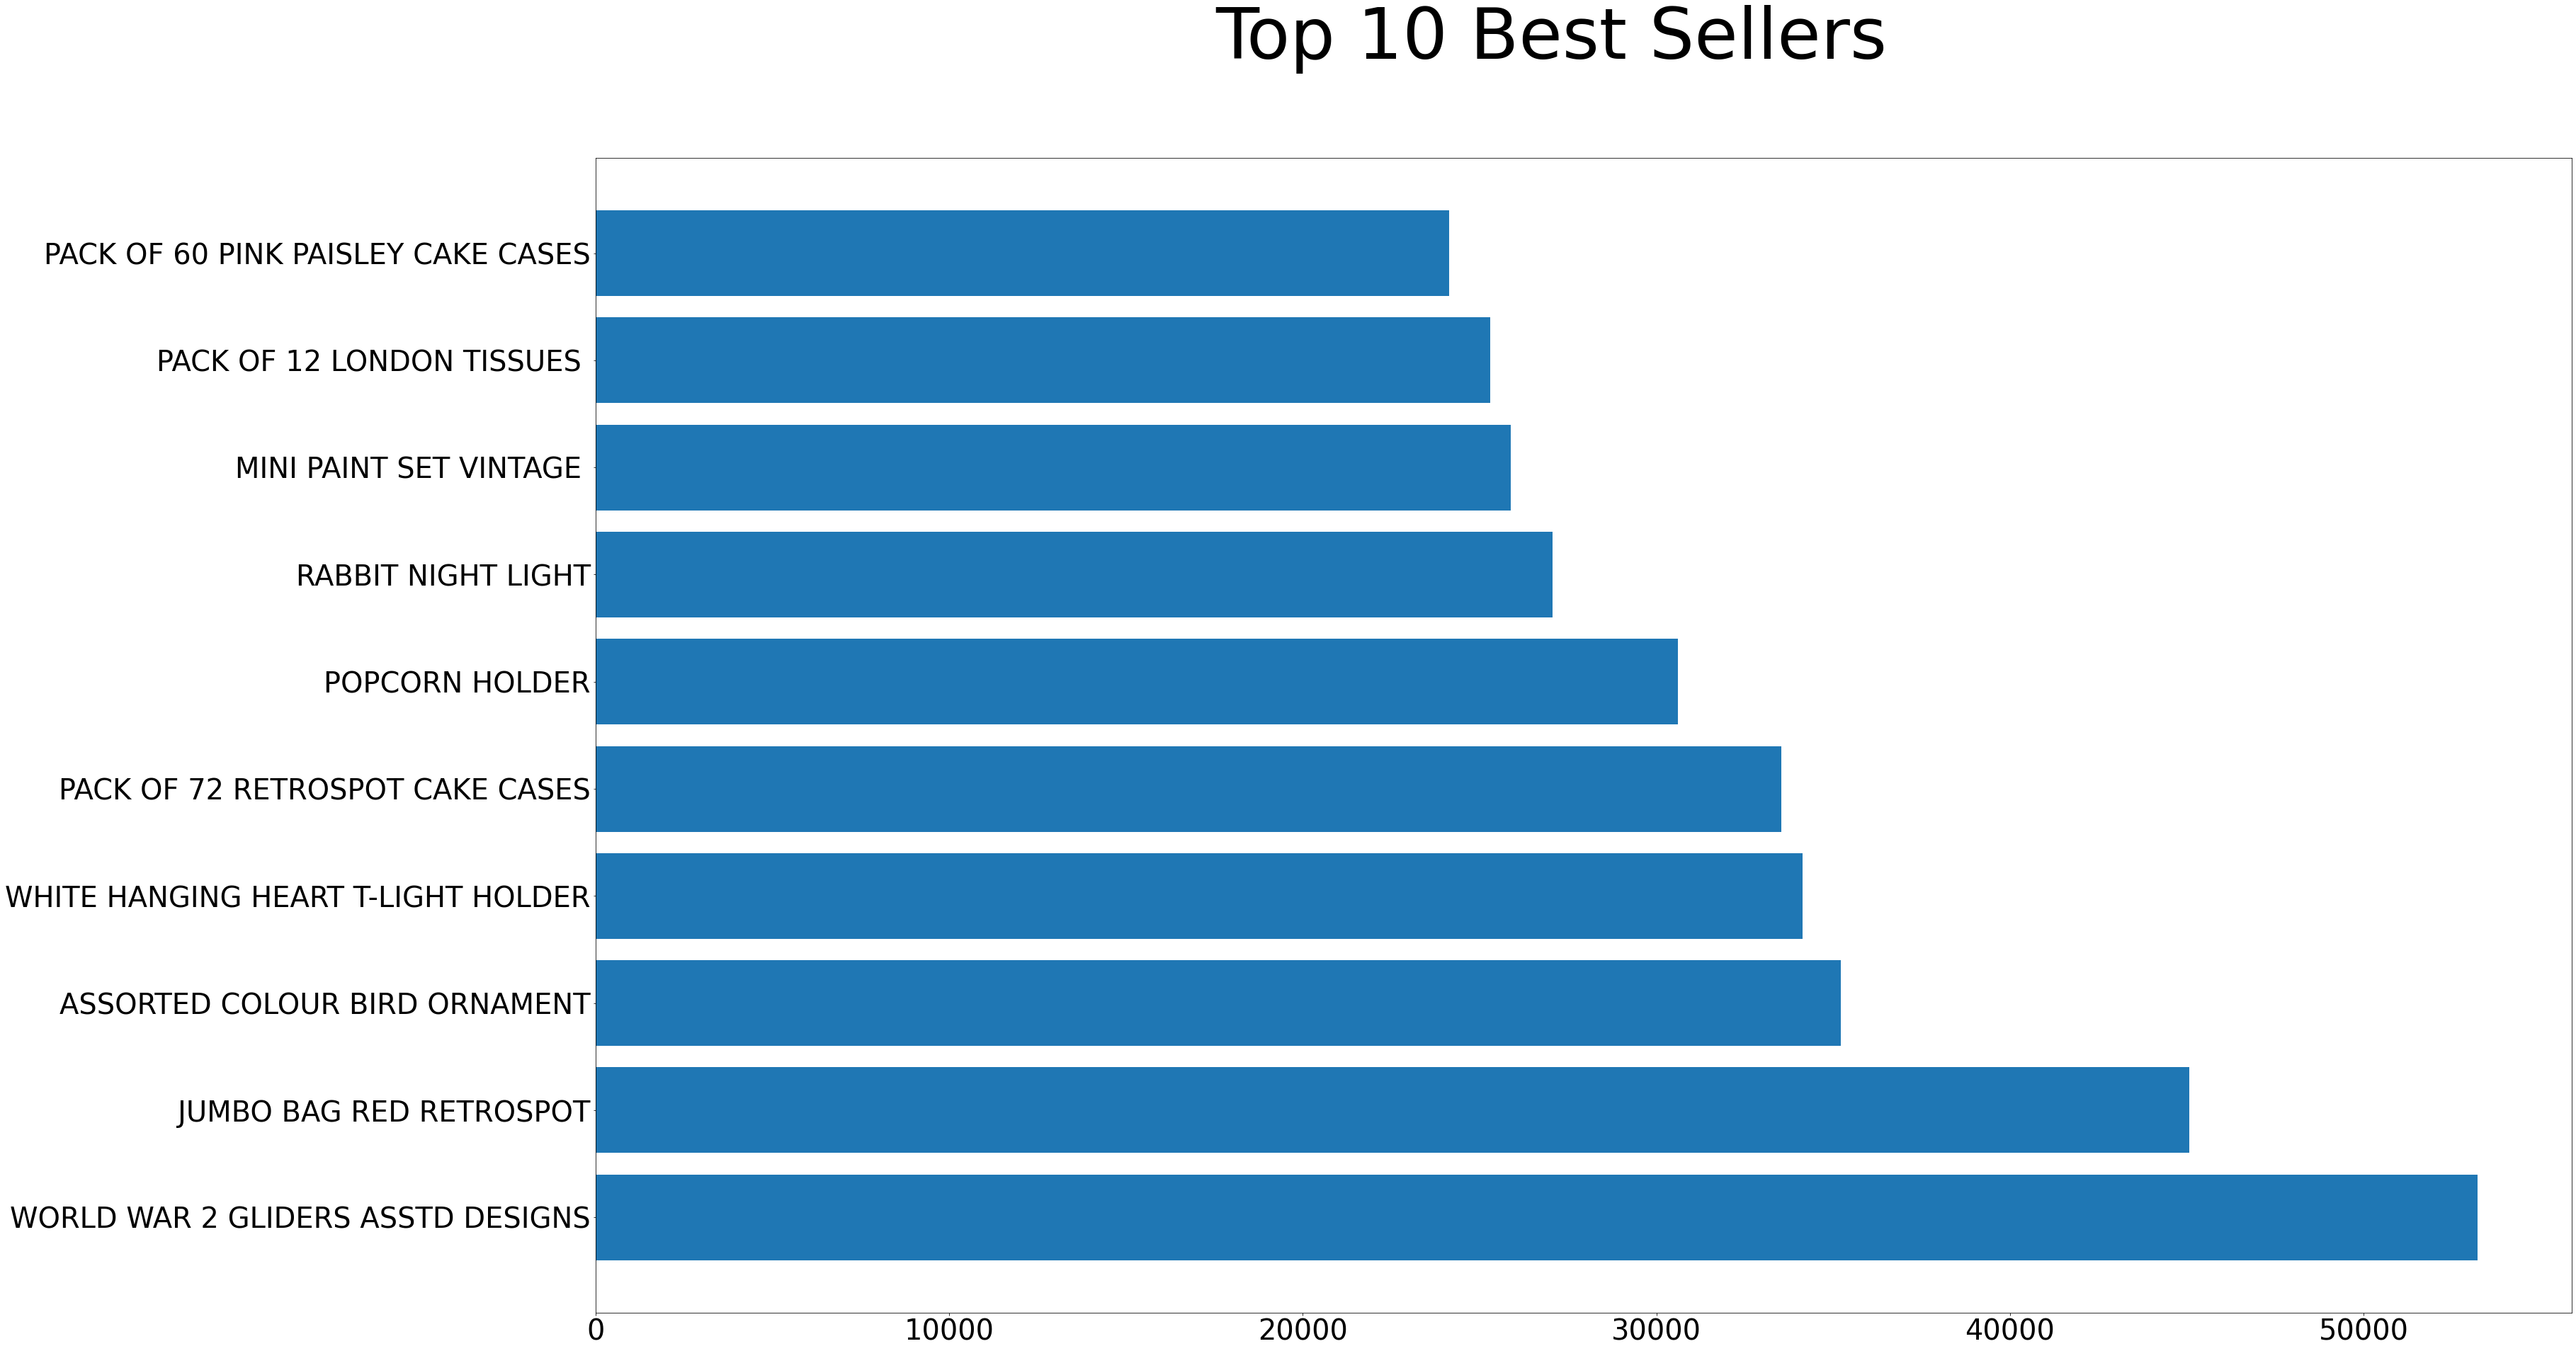

In [47]:
# plot results
plot_helper(most_requested, 'Top 10 Best Sellers')

**Analyzing products frequency in orders**

In [48]:
# create dict to maintain for each product the list of order in which it is present
most_present = {}
for _,row in tqdm(df.iterrows(), total=len(df), desc="Finding most present items.."):
    if row['ProdDescr'] not in most_present:
        most_present[row['ProdDescr']] = []
    most_present[row['ProdDescr']].append(row['BasketID'])

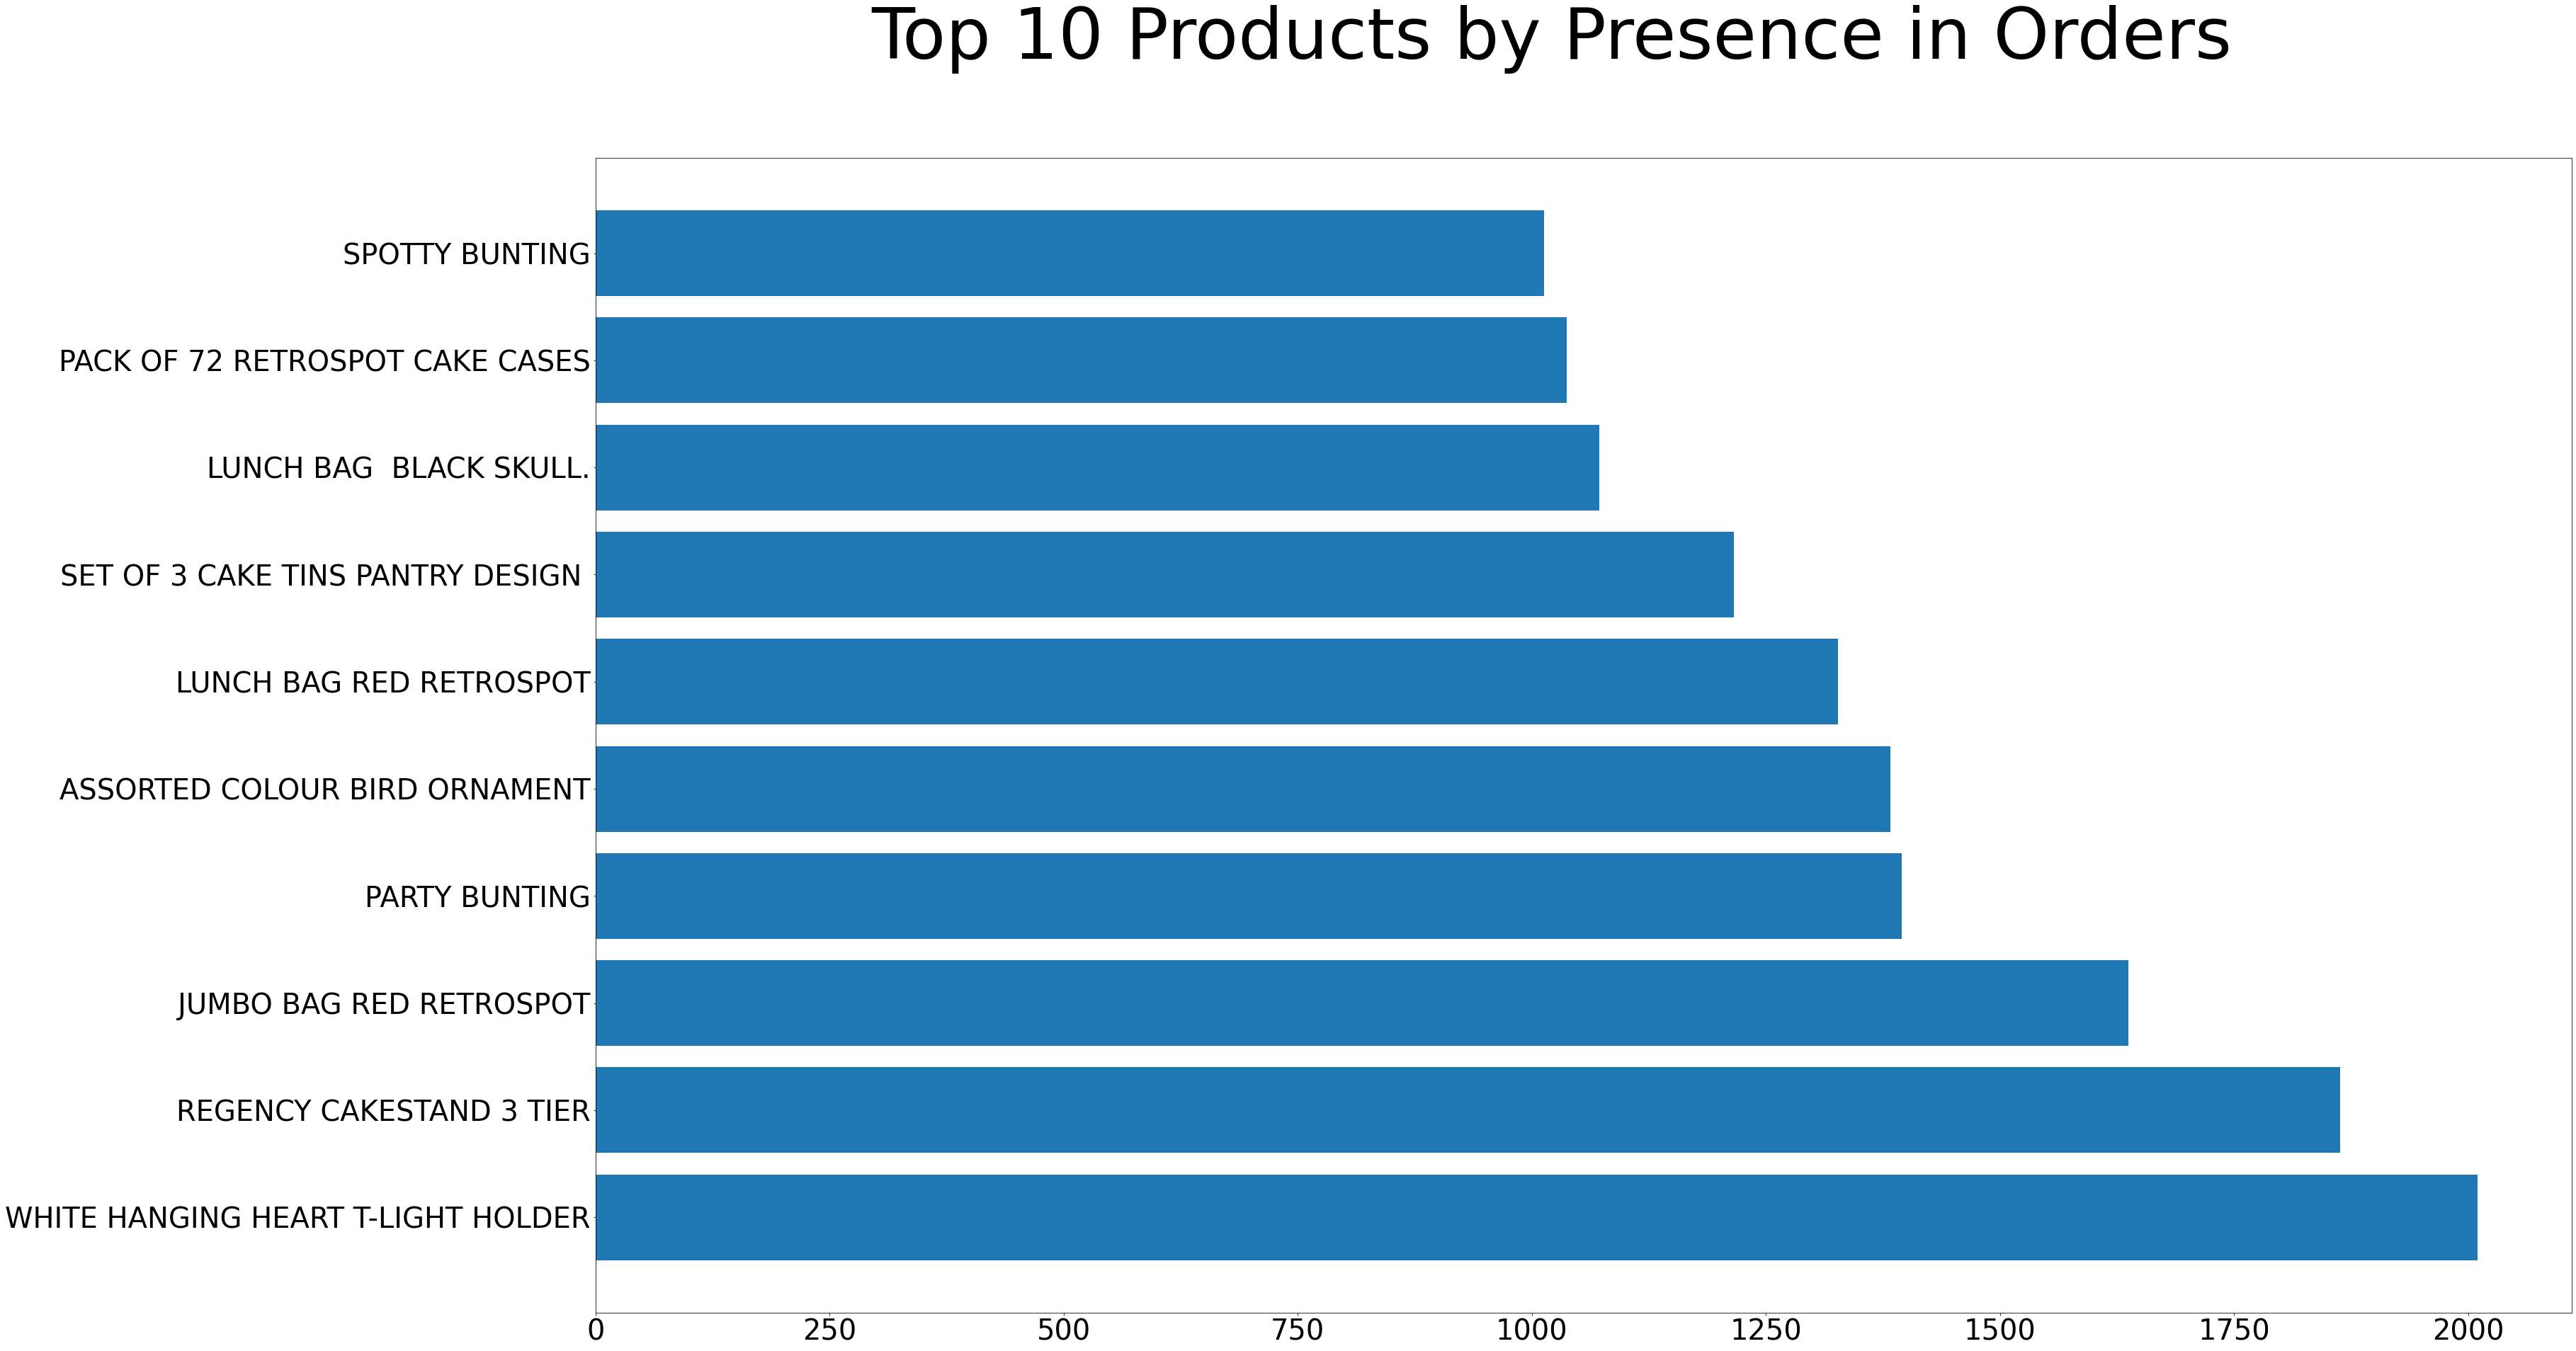

In [49]:
most_present_count = {}

for key, value in most_present.items():
    most_present_count[key] = len(set(value))
most_present_count = sorted(most_present_count.items(), key=lambda x: x[1], reverse = True)[:10]

# plot results
plot_helper(most_present_count, 'Top 10 Products by Presence in Orders')

**Analyzing distribution of orders in week days**

In [50]:
df['BasketDate'] = pd.to_datetime(df["BasketDate"]) 

orders_per_day = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0, 'Sunday': 0,}

unique_baskets = df['BasketID'].unique()

for basket in tqdm(unique_baskets, total=len(unique_baskets), desc='Finding how many orders per day of week..'):
    orders_per_day[df[df['BasketID'] == basket]['BasketDate'].dt.day_name().unique()[0]] += 1# we already made sure that each order has all its rows with same date

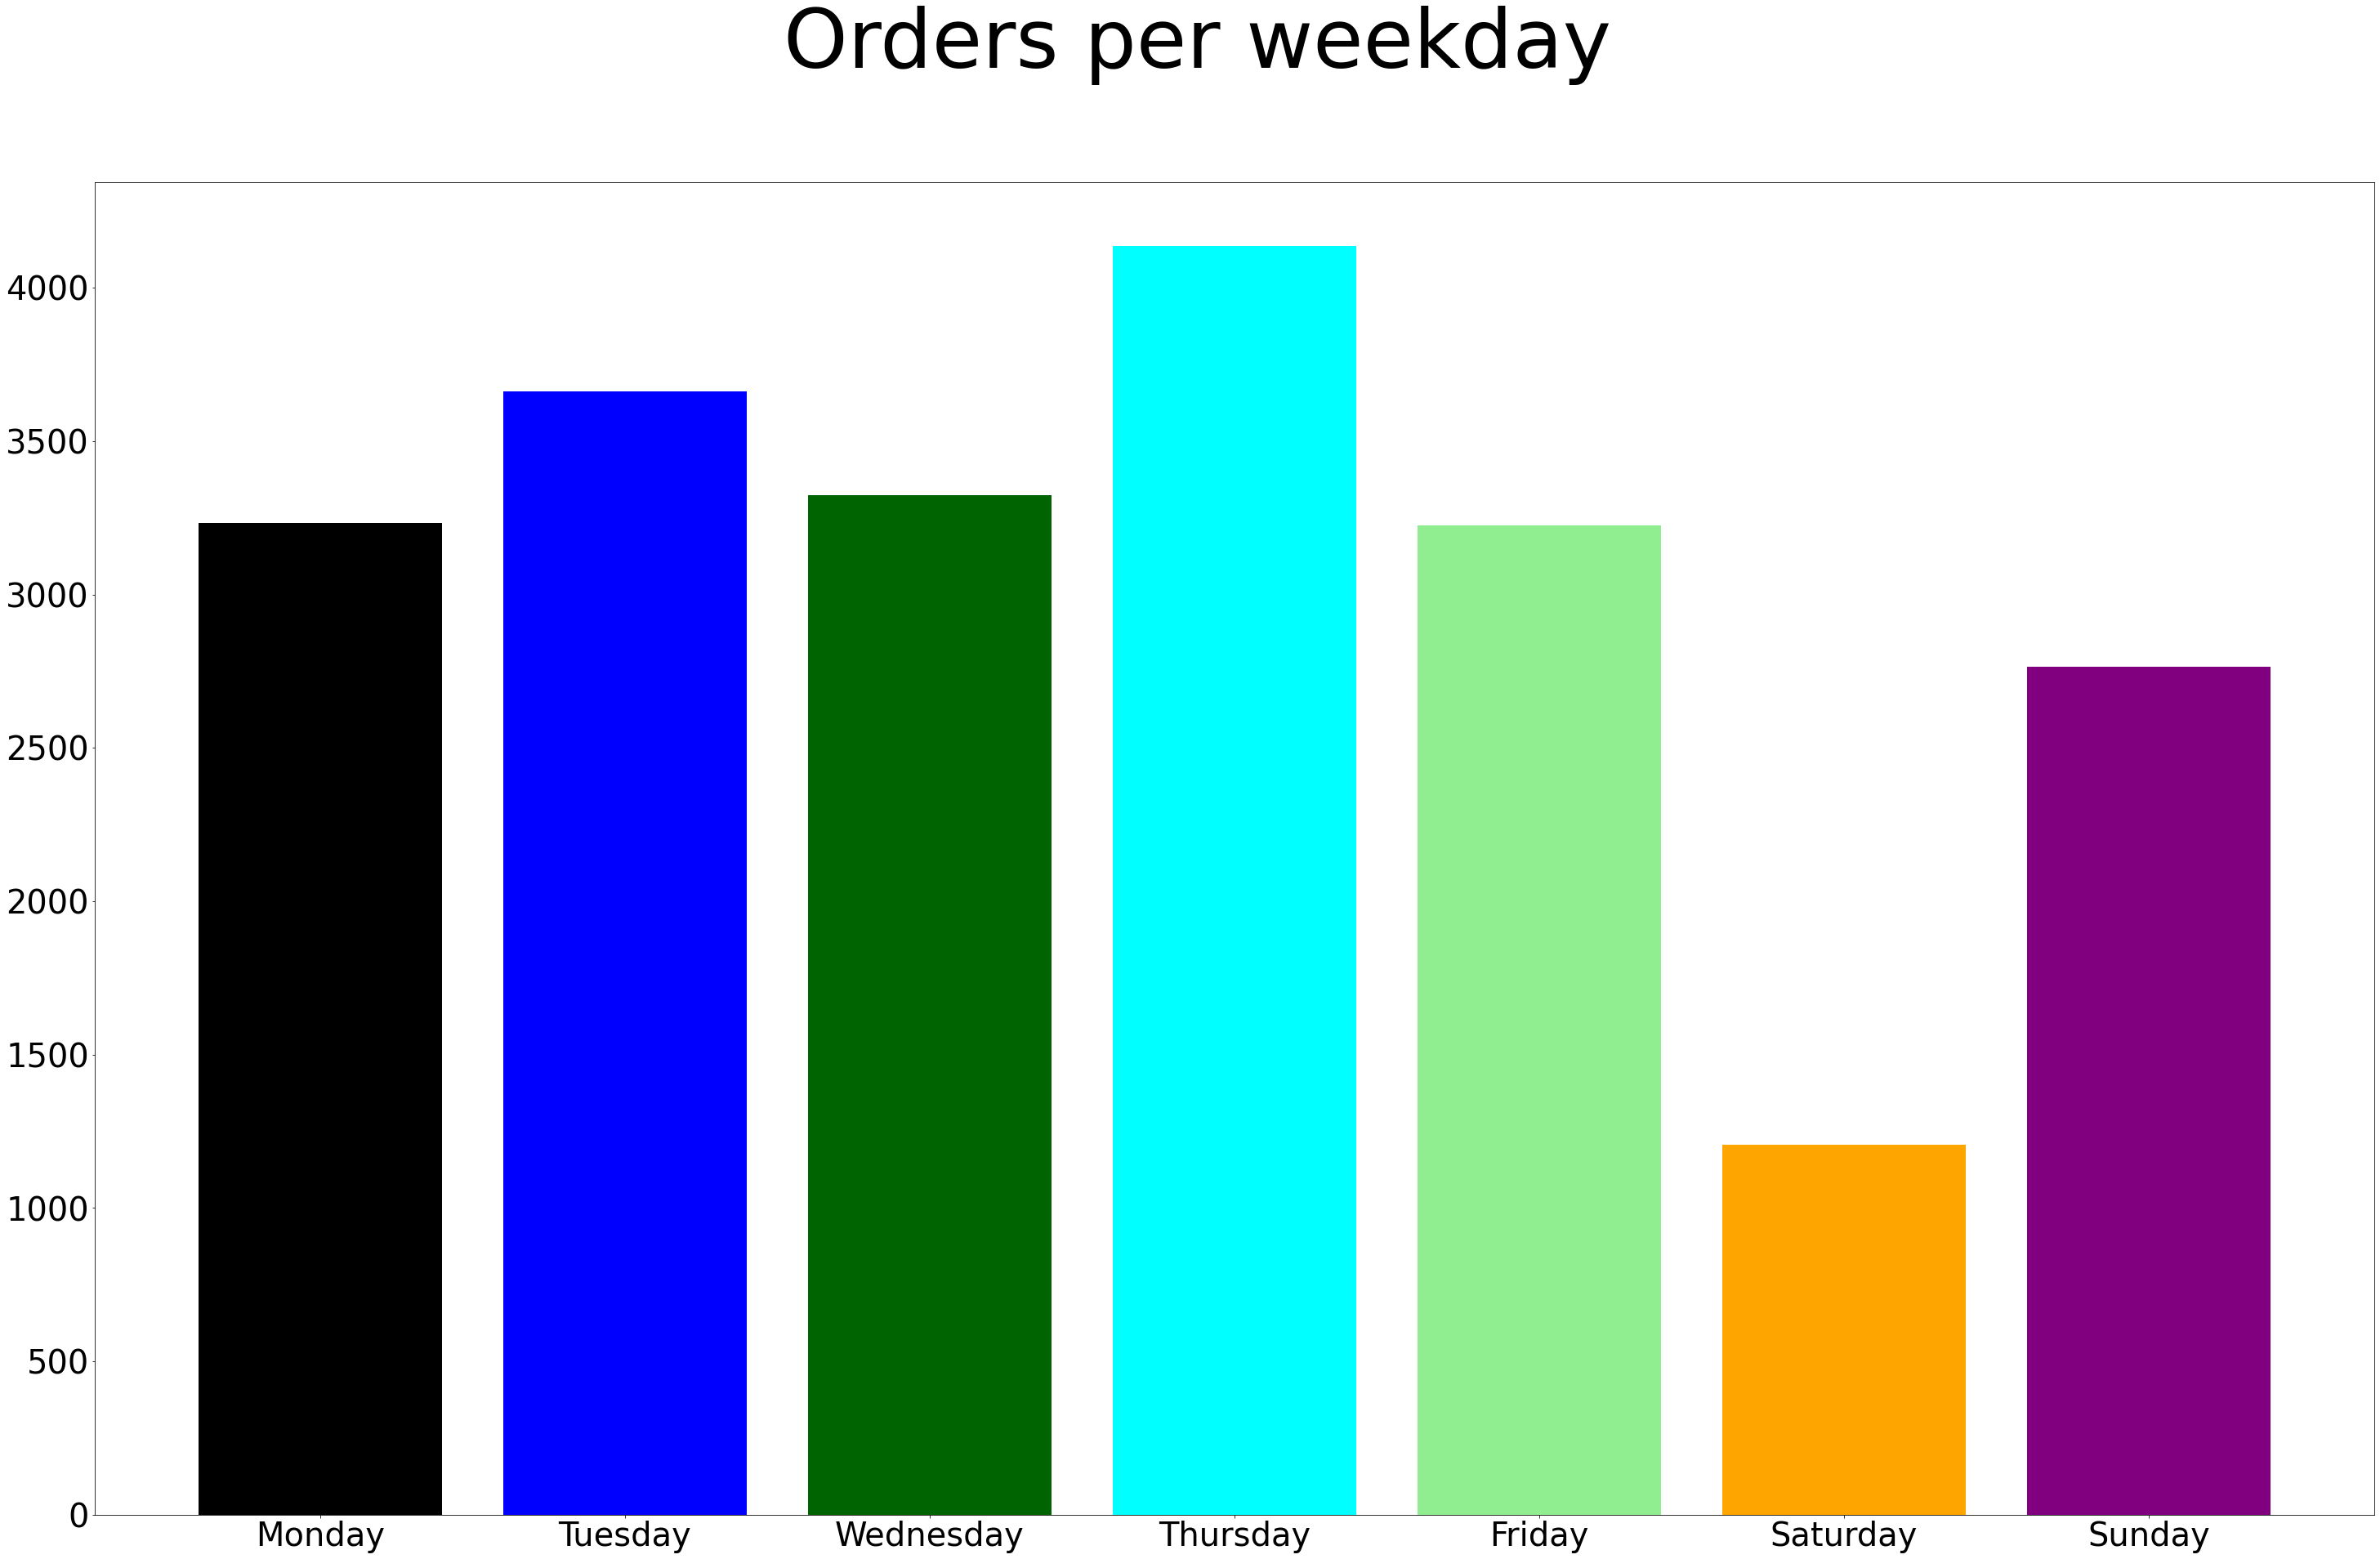

In [51]:
orders_per_day_qta = list(orders_per_day.values())
orders_per_day_label = list(orders_per_day.keys())
plt.figure(figsize=(50, 30))    
plt.suptitle('Orders per weekday', fontsize=100)
plt.bar(range(len(orders_per_day_qta)),orders_per_day_qta,color = ["black", "blue", "darkgreen", "cyan", "lightgreen", "orange", "purple"])
plt.xticks(range(len(orders_per_day_label)), orders_per_day_label, fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=40)

***

## Save cleaned dataframe in CSV format

In [54]:
path = 'datasets/cleaned_dataframe.csv'
df.to_csv(path, sep='\t')
print(f"Cleaned dataframe saved to '{path}'")

Cleaned dataframe saved to 'datasets/cleaned_dataframe.csv'
